## Comparing survey footprints

This notebook demonstrates some comparisons in the distribution of visits or coadded depths across survey footprints, adding a way to generate this comparison between different simulations. 

We often compare single-number summary statistic metric results across different runs. However, sometime we might also need to compare two full 'maps' of metric results -- comparing the number of visits per pointing between two runs, at all points in the sky, for example, to see where one simulation has added or removed coverage.


Some kinds of questions that could be tackled with these comparisons: 
* does this simulation spend more time in some parts of the sky (such as the NES or GP) than the baseline (or other comparison run)?
* did this survey achieve greater coadded depth in a given filter than the baseline?
* how does the coverage near the plane vary between these two simulations?


<a href='Getting MAF metric results'>Getting MAF metric results</a> <br>
<a href='Comparing metric results'>Comparing map-style metric results</a>


In [1]:
# Import generally useful packages
import os
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import healpy as hp
import copy

In [2]:
# Import MAF modules 
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

<a id='Getting MAF metric results'></a>

### Getting MAF metric results 

MAF saves the outputs of metric calculations in `*.npz` files, which can be read back into a metric bundle and then used to generate plots, etc., without recalculating the metric values themselves. To facilitate these footprint comparisons, we have made available pre-calculated metric results for the number of visits per healpix pointing (in all filters and per *u*, *g*, *r*, *i*, *z*, *y* filters individually) and the point-source coadded five-sigma limiting magnitude per healpix poinitng (in each of *u*, *g*, *r*, *i*, *z*, *y* filters). These were pre-calculated using a healpix slicer with nside=64. 

You can download these pre-calculated maps for the runs in the 1.5/1.6/1.7 families at <br>
https://epyc.astro.washington.edu/~lynnej/opsim_downloads/nvisits_maps.tar.gz <br>
Please set `nvisitsMapsDir` to the location of this directory (after untarring/ungzipping). 

Alternatively, you can also calculate your own metric results if these maps don't cover what you need (example, if you need visits from a single year only). We cover calculating metric values elsewhere, such as <br>https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/Introduction%20Notebook.ipynb <br>(see also other examples in the [LSST-nonproject/sims_maf_contrib](github.com/lsst-nonproject/sims_maf_contrib) repository, under both tutorials and science). These can be saved and read-back as needed.

**Read metric files from disk.**

Here we'll compare the survey footprint (all visits) between the baseline in v1.7 (baseline_nexp2_v1.7_10yrs) and one of the interesting potential new footprints in the 'footprint_tune' family, which sets up a series of variations on the combo_dust footprint (footprint_3_v1.710yrs). 

In [29]:
import glob 
dbDir = './../MAFOutput/Results_single_opsim_on_GP/'

runs = glob.glob(dbDir+"*.npz")#+"footprint*")
runs.sort()

In [30]:
runs = [i.split('/')[-1].split('_Num')[0] for i in runs]
runs


['baseline_nexp1_v1.7_10yrs',
 'baseline_nexp2_v1.7_10yrs',
 'bulges_bs_v1.5_10yrs',
 'bulges_bulge_wfd_v1.5_10yrs',
 'bulges_cadence_bs_v1.5_10yrs',
 'bulges_cadence_bulge_wfd_v1.5_10yrs',
 'bulges_cadence_i_heavy_v1.5_10yrs',
 'bulges_i_heavy_v1.5_10yrs',
 'combo_dust_nexp2_v1.6_10yrs',
 'combo_dust_v1.6_10yrs',
 'footprint_add_mag_cloudsv1.5_10yrs',
 'footprint_big_sky_dustv1.5_10yrs',
 'footprint_big_sky_nouiyv1.5_10yrs',
 'footprint_big_skyv1.5_10yrs',
 'footprint_big_wfdv1.5_10yrs',
 'footprint_bluer_footprintv1.5_10yrs',
 'footprint_gp_smoothv1.5_10yrs',
 'footprint_newAv1.5_10yrs',
 'footprint_newBv1.5_10yrs',
 'footprint_no_gp_northv1.5_10yrs',
 'footprint_standard_goalsv1.5_10yrs',
 'footprint_stuck_rollingv1.5_10yrs',
 'wfd_depth_scale0.65_noddf_v1.5_10yrs',
 'wfd_depth_scale0.70_noddf_v1.5_10yrs',
 'wfd_depth_scale0.75_noddf_v1.5_10yrs',
 'wfd_depth_scale0.80_noddf_v1.5_10yrs',
 'wfd_depth_scale0.85_noddf_v1.5_10yrs',
 'wfd_depth_scale0.90_noddf_v1.5_10yrs',
 'wfd_depth_sca

In [31]:
# dir_ = './../MAFOutput/Results_single_opsim_on_GP/'
# runs = ['bulges_bs_v1.5_10yrs', 'footprint_gp_smoothv1.5_10yrs']
bundles = {}

for r in runs:
    bundles[r] = mb.createEmptyMetricBundle()
    bundles[r].read(dbDir+r+'_NumObsMetric_USER.npz')

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More tha

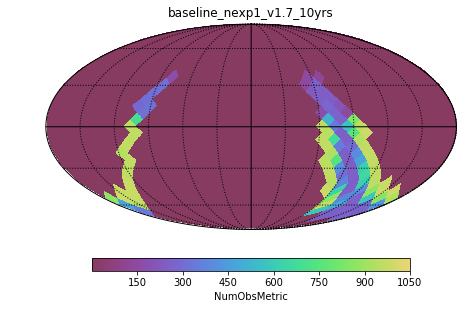

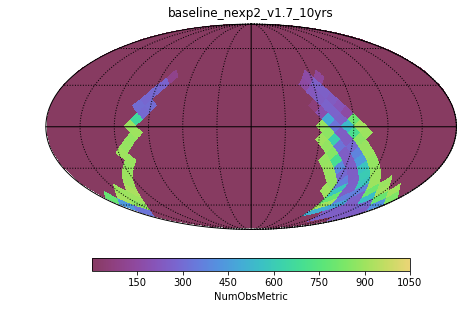

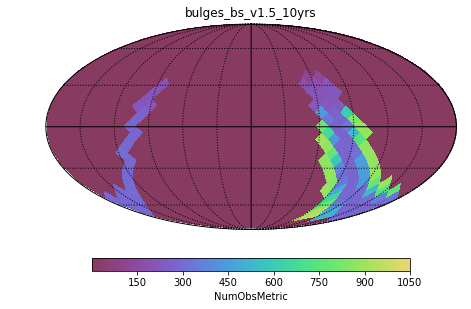

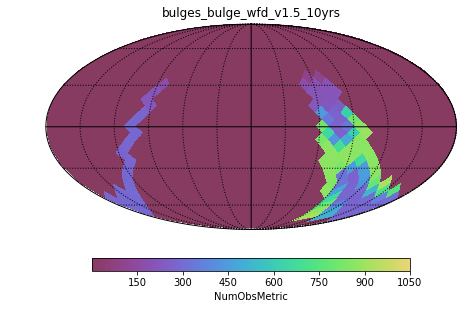

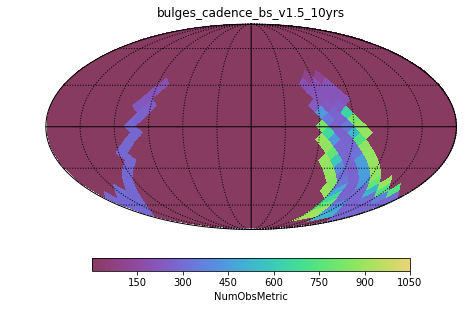

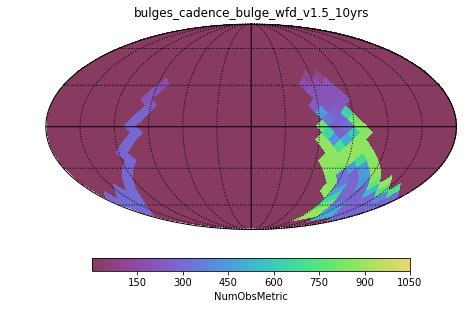

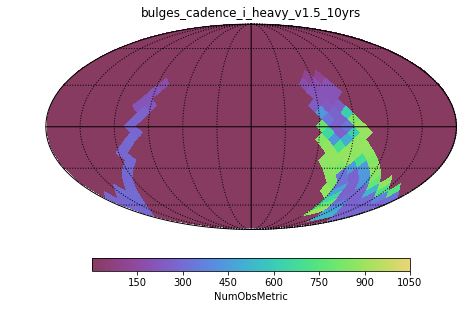

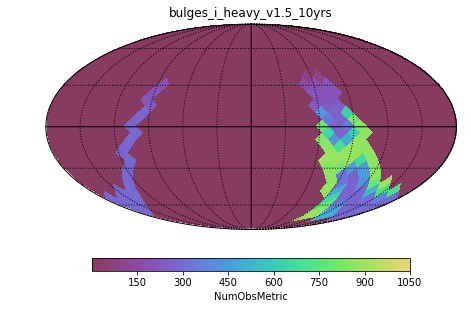

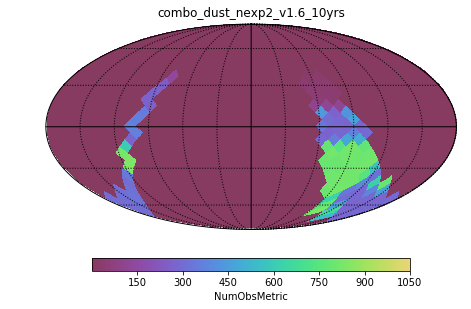

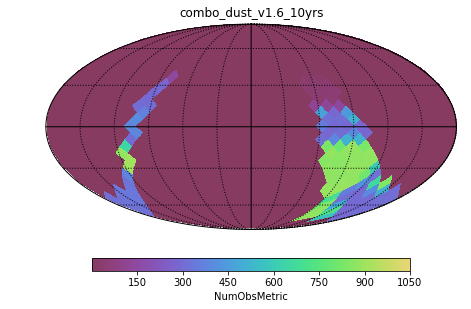

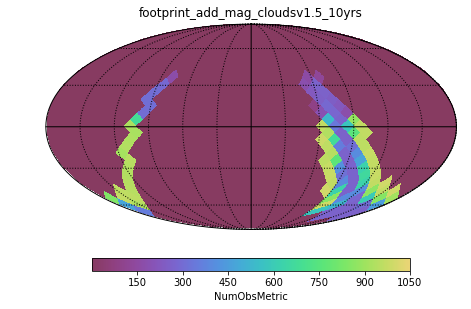

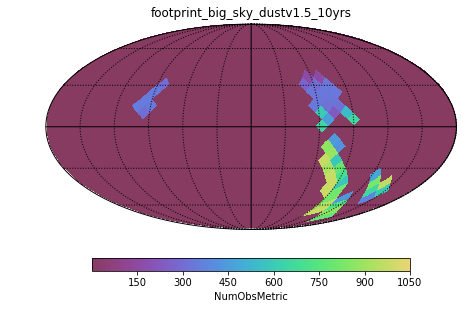

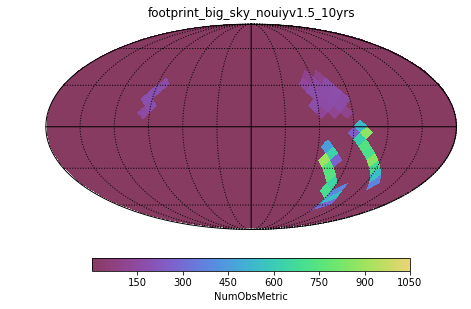

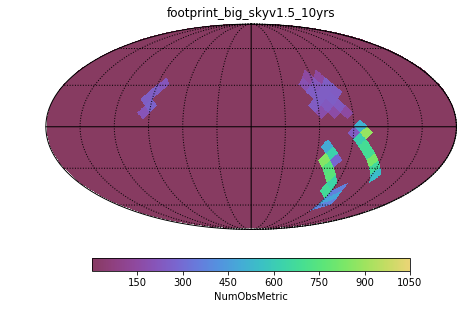

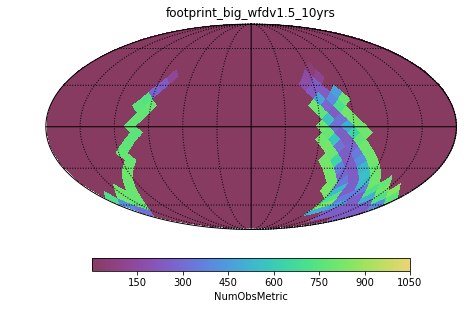

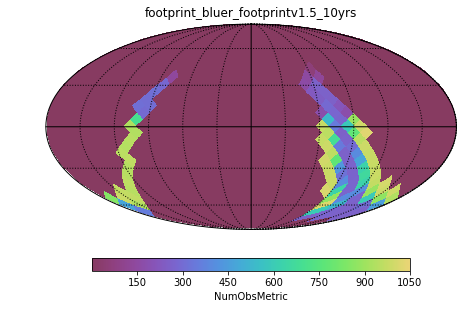

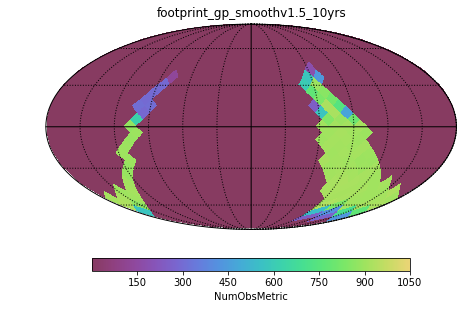

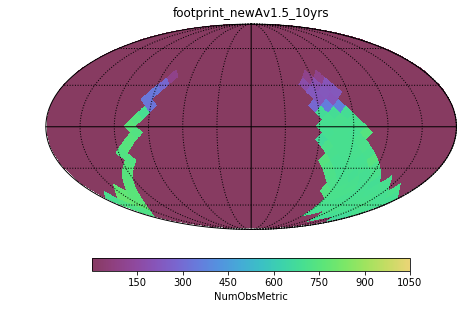

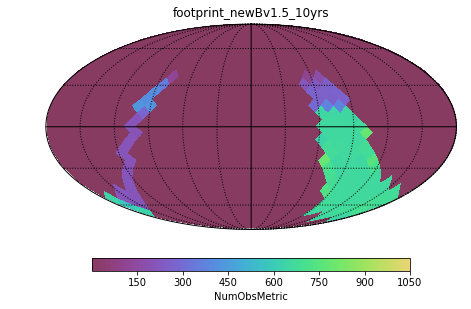

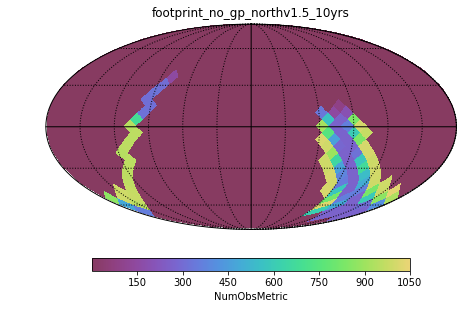

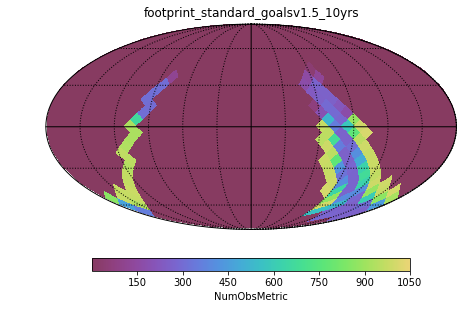

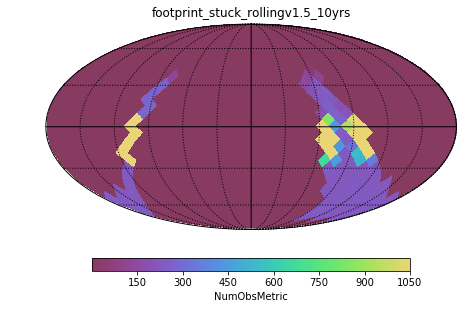

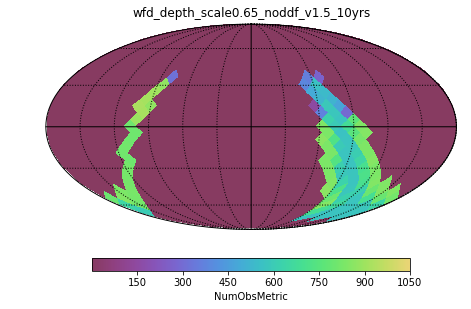

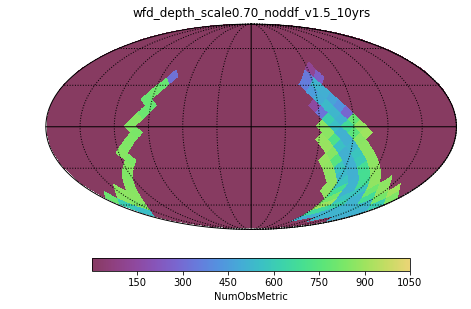

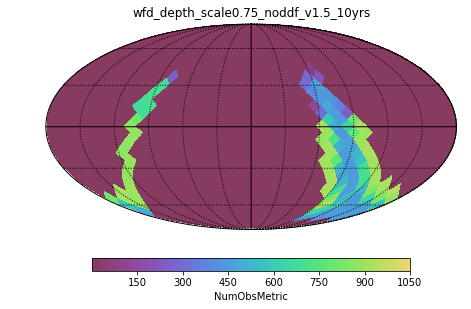

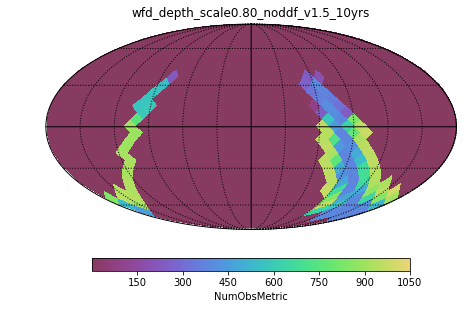

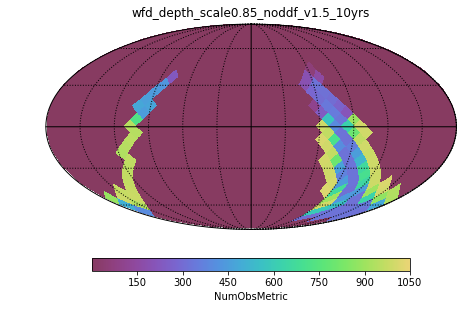

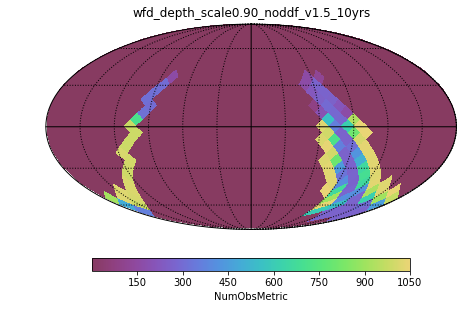

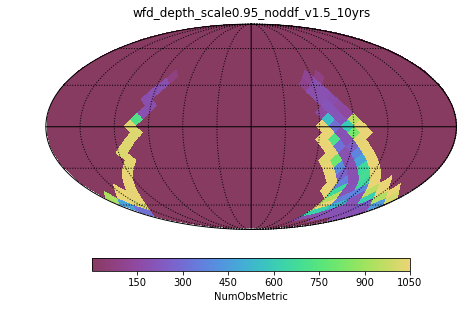

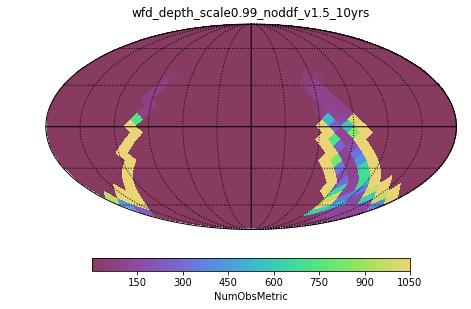

In [55]:
# Plot both -- we'll start using the PlotHandler because it's a bit easier to update plot parameters
ph = plots.PlotHandler(outDir='test', figformat='png', thumbnail=False, savefig=True)

# Just plot the sky map
plotFunc = plots.HealpixSkyMap()

for r in runs:
    plotDict = {'colorMin': 1, 'colorMax':1050, 'title':r}
    ph.setMetricBundles([bundles[r]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

In [9]:
b.metricValues.compressed()

array([250., 253., 553., ..., 214., 872., 216.])

In [57]:
nside = 64
T = 600
N = 0
medianNvis = {}
meanNvis = {}
areaT = {}
areaN = {}
area_ratio = {}
# r = '1'
for r in runs:
    medianNvis[r] = np.median(bundles[r].metricValues.compressed())
    meanNvis[r] = np.mean(bundles[r].metricValues.compressed())
    areaT[r] = len(np.where(bundles[r].metricValues > T)[0]) * hp.nside2pixarea(nside, degrees=True)
    areaN[r] = len(np.where(bundles[r].metricValues > N)[0]) * hp.nside2pixarea(nside, degrees=True)
    area_ratio[r] = (areaT[r]/3791.089395)*100

d = pd.DataFrame([meanNvis, medianNvis, areaT, areaN, area_ratio], 
                 index=['Mean Nvis', 'Median Nvis', f'Area ({T})', f'Area ({N})', f'Area ({T})/all'], columns=runs)
# d['ratio'] = d[r1] / d[r2]
# d['footprint_gp_smoothv1.5_10yrs']
# d.loc[f'Area ({T})/all', :]

In [58]:
d.to_csv('test/GP_footprint_area.csv')

<a id='Comparing metric results'></a>

### Comparing map-style metric results


**Plot original maps.**

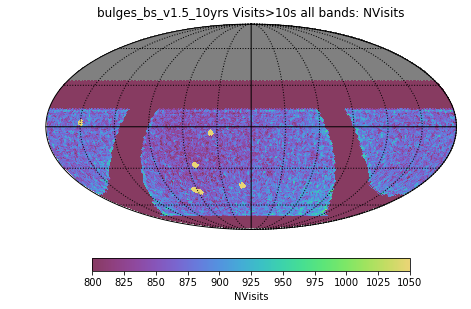

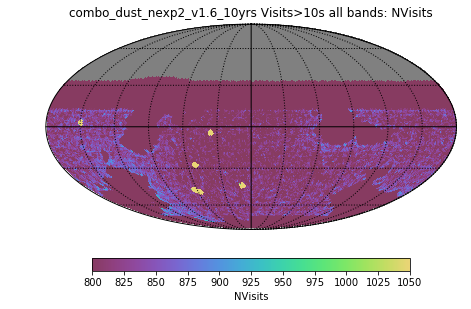

In [18]:
# Plot both -- we'll start using the PlotHandler because it's a bit easier to update plot parameters
ph = plots.PlotHandler(outDir='test', figformat='png', thumbnail=False, savefig=False)

# Just plot the sky map
plotFunc = plots.HealpixSkyMap()
plotDict = {'colorMin': 800, 'colorMax':1050}

for r in runs:
    ph.setMetricBundles([bundles[r]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

It can be hard to pick out differences by eye, although easy to notice some overall trends with these plots.
For example, the footprint_3 run clearly has a different general shape than the baseline - the coverage near the galactic plane is quite different. You may also pick out that the magellanic clouds are covered in footprint_3, while they are not in the baseline. However, it's hard to see exactly how the declination limits have changed, or how much area is shifted near the galactic plane. 
It's also clear that the baseline has a higher typical number of visits per pointing in the 'wfd' than the footprint_3 run.

However, to dive in further - we may want to look at the *difference* or perhaps the *ratio* of the number of visits at each point. 

**Calculate and store the difference information.**

In [19]:
def subtractMetricBundles(bundle1, bundle2):
    differenceVal = bundle1.metricValues.filled(0) - bundle2.metricValues.filled(0)
    mask = bundle1.metricValues.mask & bundle2.metricValues.mask
    diff = copy.deepcopy(bundle1)
    diff.plotDict = {}
    diff.runName = f'{bundle1.runName} - {bundle2.runName}'
    diff.fileRoot = 'difference'
    diff.metricValues = ma.MaskedArray(data=differenceVal, mask=mask, fill_value=hp.UNSEEN)
    return diff

In [20]:
# The difference or ratio can be calculated using the metric values in each bundle directly. 
r1 = runs[1]
r2 = runs[0]

bundles['diff'] = subtractMetricBundles(bundles[r1], bundles[r2])

**Plot the difference.**

1

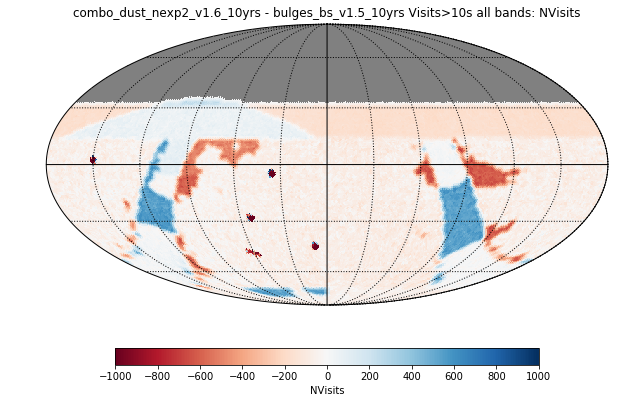

In [21]:
plotDict = {'colorMin': -1000, 'colorMax': 1000, 'cmap': 'RdBu',
           'figsize': (8, 6)}
ph.setMetricBundles([bundles['diff']])
ph.plot(plotFunc, plotDicts=plotDict)

The blue areas gain coverage in the new footprint, the red areas lose coverage. You can see how the magellanic clouds stand out, as well as small increases in area at the north and south edges of the 'wfd'. The galactic plane coverage has some complicated changes, as some areas with high dust extinction lose visits, while other areas near the bulge gain visits. 

You can also look at the amount of area covered to X number of visits by plotting each of these with the HealpixHistogram. This shows that there are some trades in amount of area covered with large or small number of visits, although they are fairly minimal. 

**Compare area histograms.**

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


1

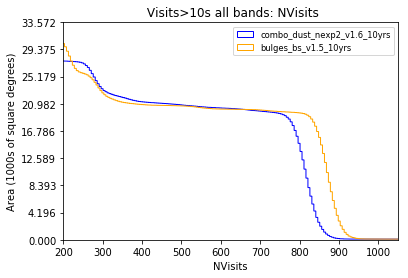

In [22]:
ph.setMetricBundles([bundles[r1], bundles[r2]])
plotDicts = [{'cumulative': -1, 'color':'blue'}, 
             {'cumulative': -1, 'color':'orange',
             'xMin':200, 'xMax': 1050}]
ph.plot(plotFunc=plots.HealpixHistogram(), plotDicts=plotDicts)

**Check out some simple comparisons.**

In [10]:
nside = 64
T = 900
N = 825
medianNvis = {}
meanNvis = {}
areaT = {}
areaN = {}
for r in runs:
    medianNvis[r] = np.median(bundles[r].metricValues.compressed())
    meanNvis[r] = np.mean(bundles[r].metricValues.compressed())
    areaT[r] = len(np.where(bundles[r].metricValues > T)[0]) * hp.nside2pixarea(nside, degrees=True)
    areaN[r] = len(np.where(bundles[r].metricValues > N)[0]) * hp.nside2pixarea(nside, degrees=True)

d = pd.DataFrame([meanNvis, medianNvis, areaT, areaN], 
                 index=['Mean Nvis', 'Median Nvis', f'Area ({T})', f'Area ({N})'], columns=runs)
d['ratio'] = d[r1] / d[r2]
d

,baseline_nexp2_v1.7_10yrs,footprint_3_v1.710yrs,ratio
Mean Nvis,718.494602,717.575724,0.998721
Median Nvis,870.000000,838.000000,0.963218
Area (900),5701.321732,1297.547975,0.227587
Area (825),17968.437650,15972.597362,0.888925


### Coadded depth

Let's repeat the above, but look at coadded depth in *i* band instead.

In [11]:
# Compare coadded depths in i band
runs = ['baseline_nexp2_v1.7_10yrs', 'footprint_3_v1.710yrs']

bundles = {}
for r in runs:
    bundles[r] = mb.createEmptyMetricBundle()
    # Note that '.' is replaced by "_" in the filenames!
    bundles[r].read(os.path.join(nvisitsMapsDir, 'npz', 
                                 f'{r.replace(".", "_")}{metricNameDict["Coadd_i"]}.npz'))
    
# The difference or ratio can be calculated using the metric values in each bundle directly. 
# (Remember to account for the 'masks', as these metricValues are numpy masked arrays)

r1 = runs[1]
r2 = runs[0]
bundles['diff'] = subtractMetricBundles(bundles[r1], bundles[r2])

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


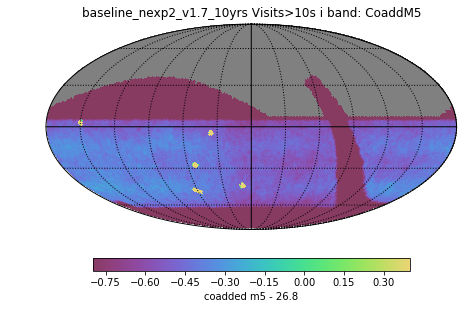

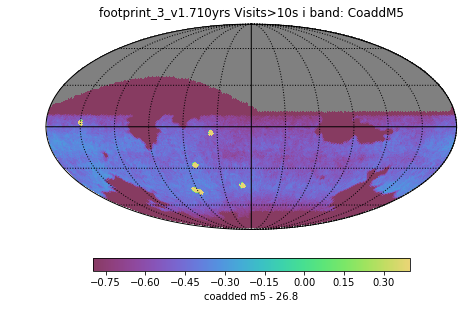

In [12]:
# Plot both -- we'll start using the PlotHandler because it's a bit easier to update plot parameters
ph = plots.PlotHandler(outDir='test', figformat='png', thumbnail=False)

# Just plot the sky map
plotFunc = plots.HealpixSkyMap()
plotDict = {'colorMin': -0.8, 'colorMax':+0.4}

for r in runs:
    ph.setMetricBundles([bundles[r]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)

1

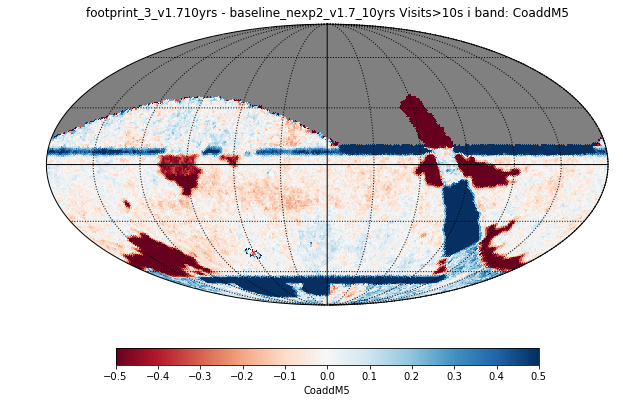

In [13]:
# Note that the *difference* is automatically centered around 0
plotDict = {'colorMin': -0.5, 'colorMax': 0.5, 'cmap': 'RdBu',
           'figsize': (8, 6)}
ph.setMetricBundles([bundles['diff']])
ph.plot(plotFunc, plotDicts=plotDict)

The differences in the coadded depth are probably more likely to be useful for looking for differences within areas with similar coverage; once you stray into area which completely changed coverage, the dynamic range is very large.
Remember these are magnitudes -- smaller values (red) = brighter limiting magnitudes, larger values (blue) = fainter limiting magnitudes.

#### One more time, all together now for visits ..

Compare two relatively similar, but different, runs, from the `footprint` family from v1.5.

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


/ssd/lsst/lsst_stack_w_2021_03/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


,footprint_big_skyv1.5_10yrs,footprint_big_sky_dustv1.5_10yrs,ratio
Mean Nvis,819.429560,783.812141,0.956534
Median Nvis,1003.000000,940.000000,0.937188
Area (900),17810.650445,17408.628789,0.977428
Area (800),18110.278276,18173.225300,1.003476


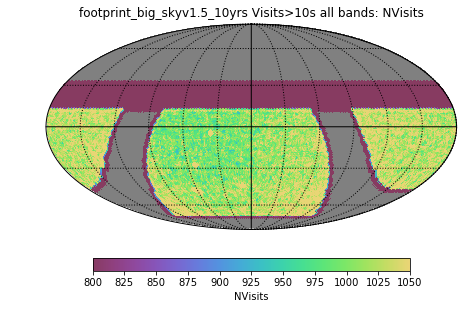

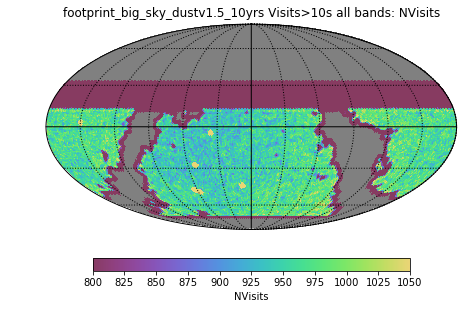

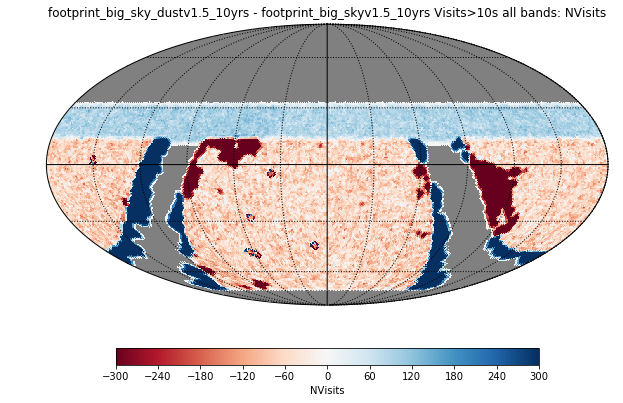

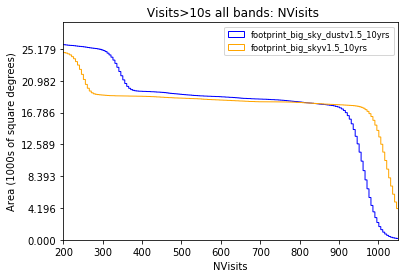

In [14]:
# Compare coadded depths in i band
runs = ['footprint_big_skyv1.5_10yrs', 'footprint_big_sky_dustv1.5_10yrs']

bundles = {}
for r in runs:
    bundles[r] = mb.createEmptyMetricBundle()
    # Note that '.' is replaced by "_" in the filenames!
    bundles[r].read(os.path.join(nvisitsMapsDir, 'npz', 
                                 f'{r.replace(".", "_")}{metricNameDict["Nvisits_all"]}.npz'))
    
# The difference or ratio can be calculated using the metric values in each bundle directly. 
# (Remember to account for the 'masks', as these metricValues are numpy masked arrays)

r1 = runs[1]
r2 = runs[0]
bundles['diff'] = subtractMetricBundles(bundles[r1], bundles[r2])


# Plot both -- we'll start using the PlotHandler because it's a bit easier to update plot parameters
ph = plots.PlotHandler(outDir='test', figformat='png', thumbnail=False, savefig=False)

# Just plot the sky map
plotFunc = plots.HealpixSkyMap()
plotDict = {'colorMin': 800, 'colorMax':1050}
for r in runs:
    ph.setMetricBundles([bundles[r]])
    ph.plot(plotFunc=plotFunc, plotDicts=plotDict)
    
plotDict = {'colorMin': -300, 'colorMax': 300, 'cmap': 'RdBu',
           'figsize': (8, 6)}
ph.setMetricBundles([bundles['diff']])
ph.plot(plotFunc, plotDicts=plotDict)

ph.setMetricBundles([bundles[r1], bundles[r2]])
plotDicts = [{'cumulative': -1, 'color':'blue'}, 
             {'cumulative': -1, 'color':'orange',
             'xMin':200, 'xMax': 1050}]
ph.plot(plotFunc=plots.HealpixHistogram(), plotDicts=plotDicts)

nside = 64
T = 900
N = 800
medianNvis = {}
meanNvis = {}
areaT = {}
areaN = {}
for r in runs:
    medianNvis[r] = np.median(bundles[r].metricValues.compressed())
    meanNvis[r] = np.mean(bundles[r].metricValues.compressed())
    areaT[r] = len(np.where(bundles[r].metricValues > T)[0]) * hp.nside2pixarea(nside, degrees=True)
    areaN[r] = len(np.where(bundles[r].metricValues > N)[0]) * hp.nside2pixarea(nside, degrees=True)

d = pd.DataFrame([meanNvis, medianNvis, areaT, areaN], 
                 index=['Mean Nvis', 'Median Nvis', f'Area ({T})', f'Area ({N})'], columns=runs)
d['ratio'] = d[r1] / d[r2]
d

/ssd/lsst/lsst_stack_w_2021_03/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


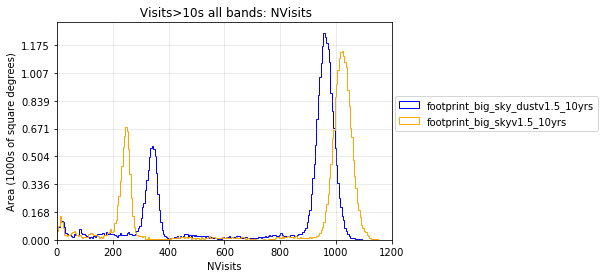

In [15]:
ph.setMetricBundles([bundles[r1], bundles[r2]])
plotDicts = [{'cumulative': 0, 'color':'blue',
             'xMin': 0, 'xMax': 1200}, 
             {'cumulative': 0, 'color':'orange',
             'xMin':0, 'xMax': 1200}]
ph.plot(plotFunc=plots.HealpixHistogram(), plotDicts=plotDicts)
plt.legend(loc=(1.01, 0.5))
plt.grid(True, alpha=0.3)